<h1><center>Semester Project</center></h1>


Over the past decades, the development of online scientific platforms like 
arXiv.org or JSTOR radically changed the way researchers access, browse, or read 
scientific articles. Yet, while observing the behavior of researchers in libraries and 
laboratories has become commonplace in the humanities, the computational study 
of digital research practices is only in its early days. This project aims at documenting 
the behavior of scientists on online platforms by making sense of the digital traces 
they generate while navigating.

During this project we are using the browsing logs of Gallica ( https://gallica.bnf.fr/ ) to make sense of user experience and identify patterns.

Project goals : 

* Parsing and sessionizing the log files in order to extract relevant sessions.
* Building an ontology based on the descriptors provided by the ARKs (Archival Resource Key, i.e. the metadata) of the documents (type of document, discipline, year, etc.)
* Using off-the-shelf Python libraries of topological data analysis (TDA) to identify the geometrical shapes of users’ paths through the ontology
* Building a typology of users’ behaviour on the platform by clustering the previously identified users’ paths

## Table Of Content:
[I. Exploring Gallica Logs](#first-bullet)

[II. Creating Sessions](#second-bullet)

[III. Word2vec Representation](#third-bullet)

[IV. Path Representation](#fourth-bullet)

[V. Path Clustering](#fifth-bullet)

[VI. Analysis](#sixth-bullet)

<a class="anchor" id="first-bullet"></a><h2><center>I. Exploring Gallica Logs</center></h2> 

## 1. Importing logs

Logs have been provided by TODO, they span from a period of TODO.

In [384]:
import os
import numpy as np


# for now I manually extracted a single file to test
file  = open('res296.log','r',encoding="utf8")
lines = file.read().splitlines()

## 2. Exploring logs

In [385]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# convert lines from logs into pandas dataframe
lines_df = pd.DataFrame(lines)

In [386]:
lines_df.head()

,0
0,##320022e99796ca35dab7e63d48fd5e7##null##null#...
1,##e7fdec50f50253f6796d61b5382155f8##null##null...
2,##320022e99796ca35dab7e63d48fd5e7##null##null#...
3,##e7fdec50f50253f6796d61b5382155f8##null##null...
4,##320022e99796ca35dab7e63d48fd5e7##null##null#...


In [387]:
# we need to split each line into relevant metadata according to this example from Nouvellet et al.

![caption](log_example.png)

In [388]:
# first split, according to the example we split by ## to get ip, pays, ville and then date/requete/procole/code/taille/référant together
lines_df=lines_df[0].str.split('##', expand=True)

In [389]:
lines_df.head()

,0,1,2,3,4
0,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:10:58:15 +0100] ""GET /ark:/12..."
1,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [03/Mar/2017:10:58:41 +0100] ""GET /ark:/12..."
2,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:11:01:15 +0100] ""GET /ark:/12..."
3,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [03/Mar/2017:11:01:41 +0100] ""GET /ark:/12..."
4,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:11:04:15 +0100] ""GET /ark:/12..."


### 2.1 Parsing HTTP requests

#### Experimenting with extracting data

In [390]:
# This is just experimental, TODO change with lazy eval regex when working on bigger data.

In [391]:
import re
import shutil
import requests
import xmltodict
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

In [392]:
'''
Function to query Gallica API and get metadata about a document from it's ark.
inputs: 
    'id': here id is the ARK of the document, that we extract from the request
Outputs:
     this function outputs the result of the API as a dictionary.

'''
def OAI(id):

    OAI_BASEURL = 'https://gallica.bnf.fr/services/OAIRecord?ark='

    url = "".join([OAI_BASEURL, id])
    #print(url)

    s = requests.get(url, stream=True)
    soup = BeautifulSoup(s.content,"lxml-xml")
    #print(soup)
    file = open('oai.xml', 'wb')
    file.write(soup.prettify().encode('UTF-8'))
    file.close()
    with open('oai.xml',encoding='UTF-8') as xml:
        doc = xmltodict.parse(xml.read())
        return doc


In [393]:
temp = pd.DataFrame()

In [394]:
# extracting the date of query
temp['Date']=lines_df.apply(lambda x: x[4].split("]")[0].split("[")[1] ,axis = 1)

In [395]:
# extracting request
temp['Request'] = lines_df.apply(lambda x: ' '.join(x[4].split("\"")[1].split(' ')[:2]),axis=1)

In [396]:
# extracting protocol, still need to look into it further
# do i really need to extract protocol at this point?
# commenting this for now until further research

# temp['protocol'] = lines_df.apply(lambda x: x[4].split("\"")[1].split(' ')[2], axis=1)

In [397]:
# extracting code
# try catch to avoid index errors, need to look into this further, what happens exactly there?
def trycode(value, default):
    try:
        return value[4].split("\"")[2].split(' ')[1]
    except (IndexError):
        return '-'
    return default


temp['Code'] = lines_df.apply(lambda x: trycode(x,'-'), axis=1)

In [398]:
# extracting length
# try catch to avoid index errors, need to look into this further, what happens exactly there?
def trylength(value, default):
    try:
        return value[4].split("\"")[2].split(' ')[2] 
    except (IndexError):
        return '-'
    return default

temp['Length'] = lines_df.apply(lambda x:  trylength(x,'-') , axis=1)

In [399]:
# extracting referant
temp['Referant'] = lines_df.apply(lambda x: x[4].split("\"")[3], axis=1)

In [400]:
# extracting ark name

#function to check if the request contains ark
def extract_ark(request):
    # capture everything between 12148 and / or between 12148 and . using regex
    ark = '-'
    ark = re.findall('(?<=12148/).+?(?=/)|(?<=12148/).+?(?=\.)', request)
    return ark


temp['Ark'] = temp.apply(lambda x: extract_ark(x['Request']), axis=1)
    

In [401]:
lines_df = lines_df.rename(columns={1:"IPAdress",2:"Country",3:"City",4:"Full_request"})

In [402]:
final_df = pd.concat([lines_df, temp],axis=1)

In [403]:
final_df[1195:1200]

,0,IPAdress,Country,City,Full_request,Date,Request,Code,Length,Referant,Ark
1195,,dd7e7fe210e8c18c7652e3f0e48700b2,France,Villemoustaussou,"- - [03/Mar/2017:18:04:59 +0100] ""GET /ark:/12...",03/Mar/2017:18:04:59 +0100,GET /ark:/12148/bpt6k1263204k.thumbnail,200,2291,http://gallica.bnf.fr/services/engine/search/s...,[bpt6k1263204k]
1196,,dd7e7fe210e8c18c7652e3f0e48700b2,France,Villemoustaussou,"- - [03/Mar/2017:18:04:59 +0100] ""GET /ark:/12...",03/Mar/2017:18:04:59 +0100,GET /ark:/12148/bpt6k5761916m.thumbnail,200,11323,http://gallica.bnf.fr/services/engine/search/s...,[bpt6k5761916m]
1197,,dd7e7fe210e8c18c7652e3f0e48700b2,France,Villemoustaussou,"- - [03/Mar/2017:18:04:59 +0100] ""GET /service...",03/Mar/2017:18:04:59 +0100,GET /services/ajax/extract/ark:/12148/bpt6k623...,200,1047,http://gallica.bnf.fr/services/engine/search/s...,[bpt6k6237463k]
1198,,dd7e7fe210e8c18c7652e3f0e48700b2,France,Villemoustaussou,"- - [03/Mar/2017:18:04:59 +0100] ""GET /ark:/12...",03/Mar/2017:18:04:59 +0100,GET /ark:/12148/bpt6k5495010c.thumbnail,200,9595,http://gallica.bnf.fr/services/engine/search/s...,[bpt6k5495010c]
1199,,dd7e7fe210e8c18c7652e3f0e48700b2,France,Villemoustaussou,"- - [03/Mar/2017:18:04:59 +0100] ""GET /service...",03/Mar/2017:18:04:59 +0100,GET /services/ajax/extract/ark:/12148/bpt6k553...,200,1065,http://gallica.bnf.fr/services/engine/search/s...,[bpt6k5535441w]


<a class="anchor" id="second-bullet"></a><h2><center>II. Creating Sessions</center></h2> 

#### 1. Creating a dataframe with IP and the difference in time between each connexion and the last

In [404]:
# Session: séquences de requêtes
# Regrouper même adresse IP => session se termine intervalle supérieur à 60 minutes entre deux requêtes. 
sessions_df = final_df.groupby('IPAdress').agg({'Ark':list,'Date':list})
sessions_df.head()

,Ark,Date
IPAdress,,
103e44bc19d6aac58db9a149c73e505b,[[]],[03/Mar/2017:18:12:04 +0100]
105781f3101367c473a91d52b6d4fd67,"[[bpt6k54673247], [bpt6k54673247], [bpt6k62397...","[03/Mar/2017:18:27:36 +0100, 03/Mar/2017:18:27..."
10907c8edc0b2702015e04f49a8204a2,"[[], [], [], [], [bpt6k6308044k], [bpt6k759364...","[03/Mar/2017:18:05:21 +0100, 03/Mar/2017:18:05..."
10915f6650d7b3ab000aafb953615c4e,"[[bpt6k33258628], [bpt6k3321225p], [bpt6k62553...","[03/Mar/2017:19:40:11 +0100, 03/Mar/2017:19:41..."
10dfc529d2b8f1a7ae6f94229848fbf,"[[bpt6k4453214], [], [], [], [], [], [], [], [...","[03/Mar/2017:18:38:47 +0100, 03/Mar/2017:18:39..."


In [405]:
from datetime import datetime
'''
Function to calculate absolute value of minutes between two dates
inputs: 
    d1: first date
    d2: second date
Outputs:
    absolute value of minutes between d1 and d2

'''
def minutes_between(d1, d2):
    d1 = datetime.strptime(d1, "%d/%b/%Y:%H:%M:%S")
    d2 = datetime.strptime(d2, "%d/%b/%Y:%H:%M:%S")
    return abs(((d2 - d1)).total_seconds() // 60.0)

In [406]:
time_beginning = "01/Jan/0001:01:01:01 +0100"
time_end = "01/Jan/3000:01:01:01 +0100"
sessions_df['date_1'] = sessions_df.apply(lambda x: [time_beginning]+x['Date'], axis = 1)
sessions_df['date_2'] = sessions_df.apply(lambda x: x['Date']+[time_end],axis=1)

In [407]:
'''
Function to calculate the difference between two zipped lists
'''
def calculate_difference_zipped_list(lst):
    new_lst = []
    for e in lst:
        if (e[0]==time_beginning):
            new_lst.append(999)
        elif (e[1]==time_end):
            new_lst.append(999)
        else:
            new_lst.append(minutes_between(e[0][:-6], e[1][:-6]))
    return new_lst
        
    

In [408]:
# this contains the ip adress and the zipped version of date_1,date_2
from collections import deque
IP_and_sessions = sessions_df.apply(lambda x: deque(calculate_difference_zipped_list(list(zip(x['date_1'],x['date_2'])))),axis=1)

In [409]:
# IP and the difference in time between each connection and the last
IP_and_sessions[:2]

IPAdress
103e44bc19d6aac58db9a149c73e505b                                           [999, 999]
105781f3101367c473a91d52b6d4fd67    [999, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

#### 2. Enriching the original dataframe with previous connexion date column, this will be useful when we try to set a timeout to define a session

In [410]:
# index on ipadress/date
# queue 
final_df['previous_connexion_date']=final_df.apply(lambda x: IP_and_sessions[x['IPAdress']].popleft(),axis=1)

In [411]:
final_df.head(2)

,0,IPAdress,Country,City,Full_request,Date,Request,Code,Length,Referant,Ark,previous_connexion_date
0,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:10:58:15 +0100] ""GET /ark:/12...",03/Mar/2017:10:58:15 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],999.0
1,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [03/Mar/2017:10:58:41 +0100] ""GET /ark:/12...",03/Mar/2017:10:58:41 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],999.0


#### 3. Assigning a session ID to each connection according to the set rules we have set above

In [412]:
'''
Function to query Gallica API and get metadata about a document from it's ark.
inputs: 
    'id': here id is the ARK of the document, that we extract from the request
Outputs:
     this function outputs the result of the API as a dictionary.

'''
session_id=0
def create_session(period):
    global session_id
    if(period>30):
        session_id += 1
    return session_id

In [413]:
final_df

,0,IPAdress,Country,City,Full_request,Date,Request,Code,Length,Referant,Ark,previous_connexion_date
0,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:10:58:15 +0100] ""GET /ark:/12...",03/Mar/2017:10:58:15 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],999.0
1,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [03/Mar/2017:10:58:41 +0100] ""GET /ark:/12...",03/Mar/2017:10:58:41 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],999.0
2,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:11:01:15 +0100] ""GET /ark:/12...",03/Mar/2017:11:01:15 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],3.0
3,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [03/Mar/2017:11:01:41 +0100] ""GET /ark:/12...",03/Mar/2017:11:01:41 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],3.0
4,,320022e99796ca35dab7e63d48fd5e7,null,null,"- - [03/Mar/2017:11:04:15 +0100] ""GET /ark:/12...",03/Mar/2017:11:04:15 +0100,GET /ark:/12148/bpt6k70211m,503,-,-,[],3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
170099,,62d6ebcb4c44ac6bc6b36479640341a9,United States,Mountain View,"- - [04/Mar/2017:05:20:40 +0100] ""GET /assets/...",04/Mar/2017:05:20:40 +0100,GET /assets/static/javascripts/vendor/jquery.m...,200,1261,http://gallica.bnf.fr/ark:/12148/btv1b10542978v,[],0.0
170100,,e7fdec50f50253f6796d61b5382155f8,null,null,"- - [04/Mar/2017:05:20:41 +0100] ""GET /ark:/12...",04/Mar/2017:05:20:41 +0100,GET /ark:/12148/bpt6k70211m,200,32736,-,[],1.0
170101,,62d6ebcb4c44ac6bc6b36479640341a9,United States,Mountain View,"- - [04/Mar/2017:05:20:42 +0100] ""GET /ark:/12...",04/Mar/2017:05:20:42 +0100,GET /ark:/12148/bpt6k209278x.thumbnail,200,2576,-,[bpt6k209278x],0.0
170102,,62d6ebcb4c44ac6bc6b36479640341a9,United States,Mountain View,"- - [04/Mar/2017:05:20:47 +0100] ""GET /ark:/12...",04/Mar/2017:05:20:47 +0100,GET /ark:/12148/btv1b8439376v,302,20,-,[],0.0


In [414]:
final_df=final_df.sort_values(by=['IPAdress','Date'])
final_df['session_id'] = final_df.apply(lambda x: create_session(x['previous_connexion_date']),axis=1)

#### 4. Creating sessions by grouping by session ID and collecting all ARKs


In [416]:
sessions = final_df.groupby('session_id').agg({'Ark':list})

In [423]:
# removing subsequent ARKs and remove empty lists
def remove_consecutive_duplicates(l):
    return [v for i, v in enumerate(l) if (i == 0 or v != l[i-1]) and v!=[]]

    
sessions['Ark'] = sessions.apply(lambda x: remove_consecutive_duplicates(x['Ark']), axis = 1)

In [432]:
sessions = sessions[sessions['Ark'].apply(lambda x: len(x)>1)]

#### 5. Converting arks from sessions to document titles

In [433]:
'''
get titles from ARKs

Input: list of arks

Output: list of document titles

'''
def get_title_from_ark(l):
    temp = []
    for ark in l:  
        title = ''
        if(len(ark)>0):
            oai_result = OAI(ark[0]) 
            if(oai_result != None ):
                try:
                    title = oai_result.get('results').get('notice').get('record').get('metadata').get('oai_dc:dc').get('dc:title')
                except:
                    title = ''
                
        temp.append(title)
    return temp

In [434]:
'''
get titles from ARKs using caching, if a user opens the same document twice we do not do any API call

Input: list of arks

Output: list of document titles

'''
def get_title_from_ark_cache(l):
    temp = []
    cache = {}
    for ark in l:  
        title = ''
        # remembering that l is a list of list [[ark1],[ark2],[ark3]]
        # if ark is not empty
        if(len(ark)>0):
            # check if ark in cache
            if ark[0] in cache:
                temp.append(cache.get(ark))
                continue
            else:            
                oai_result = OAI(ark[0]) 
                if(oai_result != None ):
                    try:
                        title = oai_result.get('results').get('notice').get('record').get('metadata').get('oai_dc:dc').get('dc:title')
                        cache["ark"]=title
                    except:
                        title = ''

        temp.append(title)
    return temp

In [435]:
sessions

,Ark
session_id,
2,"[[bpt6k54673247], [bpt6k6239727c], [bpt6k22425..."
3,"[[bpt6k6308044k], [bpt6k759364m], [bpt6k757724..."
4,"[[bpt6k33258628], [bpt6k3321225p], [bpt6k62553..."
7,"[[bpt6k127220w], [bpt6k127254f]]"
13,"[[bpt6k8841151m], [bpt6k8844497k]]"
...,...
1133,"[[btv1b55008737g], [bpt6k5828340h]]"
1136,"[[bpt6k83674j], [bpt6k9748620x], [bpt6k940483x..."
1142,"[[bpt6k566093b], [bpt6k5818784], [bpt6k759364m..."


In [442]:
# testing on 5 sessions, API calls are taking a bit too much time so far.
sessions_5 = sessions[:50]

In [441]:
sessions_5['document_titles_path'] = sessions_5.apply(lambda x: get_title_from_ark_cache(x['Ark']),axis = 1)

KeyboardInterrupt: 

In [443]:

# TODO: contact Gallica ?
sessions_5

,Ark
session_id,
2,"[[bpt6k54673247], [bpt6k6239727c], [bpt6k22425..."
3,"[[bpt6k6308044k], [bpt6k759364m], [bpt6k757724..."
4,"[[bpt6k33258628], [bpt6k3321225p], [bpt6k62553..."
7,"[[bpt6k127220w], [bpt6k127254f]]"
13,"[[bpt6k8841151m], [bpt6k8844497k]]"
14,"[[bpt6k527557b], [bpt6k6238683], [bpt6k8166927..."
15,"[[bpt6k1255459k], [bpt6k1255459k], [bpt6k12554..."
16,"[[bpt6k48037855], [bpt6k48037855], [bpt6k48037..."
17,"[[btv1b53006749m], [btv1b53006749m], [btv1b530..."


#### 6. Converting arks to themes

First we start by making a dictionary of gallica themes, how we obtain those themes is explained in this link https://api.bnf.fr/fr/api-gallica-de-recherche where each index has a signification:

            0 = Généralités
			1 = Philosophie et psychologie
			2 = Religion
			3 = Économie et société
			4 = Langues
			5 = Sciences
			6 = Techniques
			7 = Arts et loisirs
			8 = Littérature
			9 = Histoire et géographie
            
            
TODO: implement caching for both solutions, one query for both title and themes



In [437]:
# dictionary of gallica themes, useful to interpret results from Gallica API queries
dewey_classification = {}
f = open("dewey.txt", "r",encoding='utf-8')
for x in f:
    try:
        if(x[2:4]=='0 '):
            dewey_classification[x[0:2]]= x[4:].rstrip()
    except:
        continue
        
index_to_themes=dewey_classification

In [446]:
'''
get themes from ARKs using caching, if a user opens the same document twice we do not do any API call

Input: list of arks

Output: list of document titles

'''

def get_theme_from_ark_cache(l):
    temp = []
    cache = {}
    # regular expression to only catch fields containing theme
    r = re.compile(".*theme")
    for ark in l:  
        theme = ''
        # remembering that l is a list of list [[ark1],[ark2],[ark3]]
        # if ark is not empty
        if(len(ark)>0):
            # check if ark in cache
            if ark[0] in cache:
                temp.append(cache.get(ark))
                continue
            else:            
                oai_result = OAI(ark[0]) 
                if(oai_result != None ):
                    try:
                        theme = oai_result.get('results').get('notice').get('record').get('header').get('setSpec')
                        theme = list(filter(r.match, theme))[0].split(':')[3][:2] # Read Note
                        theme = index_to_themes.get(theme)
                        cache["ark"]=theme
                    except:
                        theme = ''

        temp.append(theme)
    print('-')
    return temp

In [447]:
# visualising one path with themes
sessions_5['document_theme_path'] = sessions_5.apply(lambda x: get_theme_from_ark_cache(x['Ark']),axis = 1)

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [449]:
sessions_5

,Ark,document_theme_path
session_id,,
2,"[[bpt6k54673247], [bpt6k6239727c], [bpt6k22425...","[Médias documentaires, journalisme, édition, H..."
3,"[[bpt6k6308044k], [bpt6k759364m], [bpt6k757724...","[Médias documentaires, journalisme, édition, M..."
4,"[[bpt6k33258628], [bpt6k3321225p], [bpt6k62553...",[Administration publique. Art et science milit...
7,"[[bpt6k127220w], [bpt6k127254f]]","[, ]"
13,"[[bpt6k8841151m], [bpt6k8844497k]]","[, ]"
14,"[[bpt6k527557b], [bpt6k6238683], [bpt6k8166927...","[Médias documentaires, journalisme, édition, M..."
15,"[[bpt6k1255459k], [bpt6k1255459k], [bpt6k12554...","[Économie, Économie, Économie, Économie, Écono..."
16,"[[bpt6k48037855], [bpt6k48037855], [bpt6k48037...",[Littératures des langues helléniques. Littéra...
17,"[[btv1b53006749m], [btv1b53006749m], [btv1b530...","[, , , , ]"


#### 7. TODO Adding sub themes 

<a class="anchor" id="third-bullet"></a><h2><center>III. Word2vec Representation</center></h2> 

In this part I will try to represent the arks in a 2D dimension using word2vec, each ark will be assigned a vector.

Word2vec model is trained directly from the requests.

Choice between 2 models : 
* Skip-gram: Model will take one word as input, but it will return multiple words as per window size.
* CBOW (Continuous Bag of Words): takes the context of each word as the input and tries to predict the word corresponding to the context. 


#### 2. Creating corpus

Our corpus would be represented as [ [ ark1 , referant_ark1 ] , [ ark2 , referant_ark2 ], [ ark2 , referant_ark2 ] ... ] 

TODO: change repr to [ark1,ark2,ark3,ark4]

In [450]:
# Create the list of list format of the custom corpus for gensim modeling 
corpus = [row for row in sessions_5['document_theme_path']]

In [451]:
# view corpus
corpus[0]

['Médias documentaires, journalisme, édition',
 "Histoire générale du monde ancien, jusqu'à 499 apr. J.-C.",
 'Médias documentaires, journalisme, édition',
 'Généralités sur l’informatique, l’information, ouvrages généraux',
 'Généralités sur la Géographie et l’Histoire',
 'Médias documentaires, journalisme, édition',
 'Généralités sur la Géographie et l’Histoire',
 'Droit',
 'Histoire générale de l’Europe',
 'Fabrication industrielle',
 "Littérature (Belles-lettres) et techniques d'écriture",
 'Sciences sociales',
 '',
 'Agronomie, agriculture et activités connexes',
 'Administration publique. Art et science militaire',
 'Droit',
 'Droit']

In [452]:
len(corpus)

50

#### 3. Inputing corpus to the model

In [453]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

* size: The number of dimensions of the embeddings and the default is 100.
* window: The maximum distance between a target word and words around the target word. The default window is 5.
* min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
* workers: The number of partitions during training and the default workers is 3.
* sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [607]:
model = Word2Vec(corpus, min_count=2,size= 100,workers=3, window =3, sg = 1)

#### 5. Model results + T-SNE representation

In [608]:
# trying the model with one word
model.wv.most_similar('Religion')

[('Sciences sociales', 0.9992186427116394),
 ('Généralités sur la Géographie et l’Histoire', 0.9991476535797119),
 ("Histoire et géographie du christianisme et de l'Église",
  0.9990431070327759),
 ('Littérature des langues romanes. Littérature française',
  0.9989975690841675),
 ('Loisirs et arts du spectacle. Sports', 0.998881459236145),
 ('Médias documentaires, journalisme, édition', 0.9988810420036316),
 ('Administration publique. Art et science militaire', 0.9988698959350586),
 ('Sciences médicales. Médecine', 0.998828649520874),
 ('Littératures des langues helléniques. Littérature grecque classique',
  0.9987601637840271),
 ('Bibliographie', 0.9987446665763855)]

In [609]:
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import re
import matplotlib.pyplot as plt
import matplotlib as mpl

vocab = list(model.wv.vocab)
X = model.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df = df.drop('')

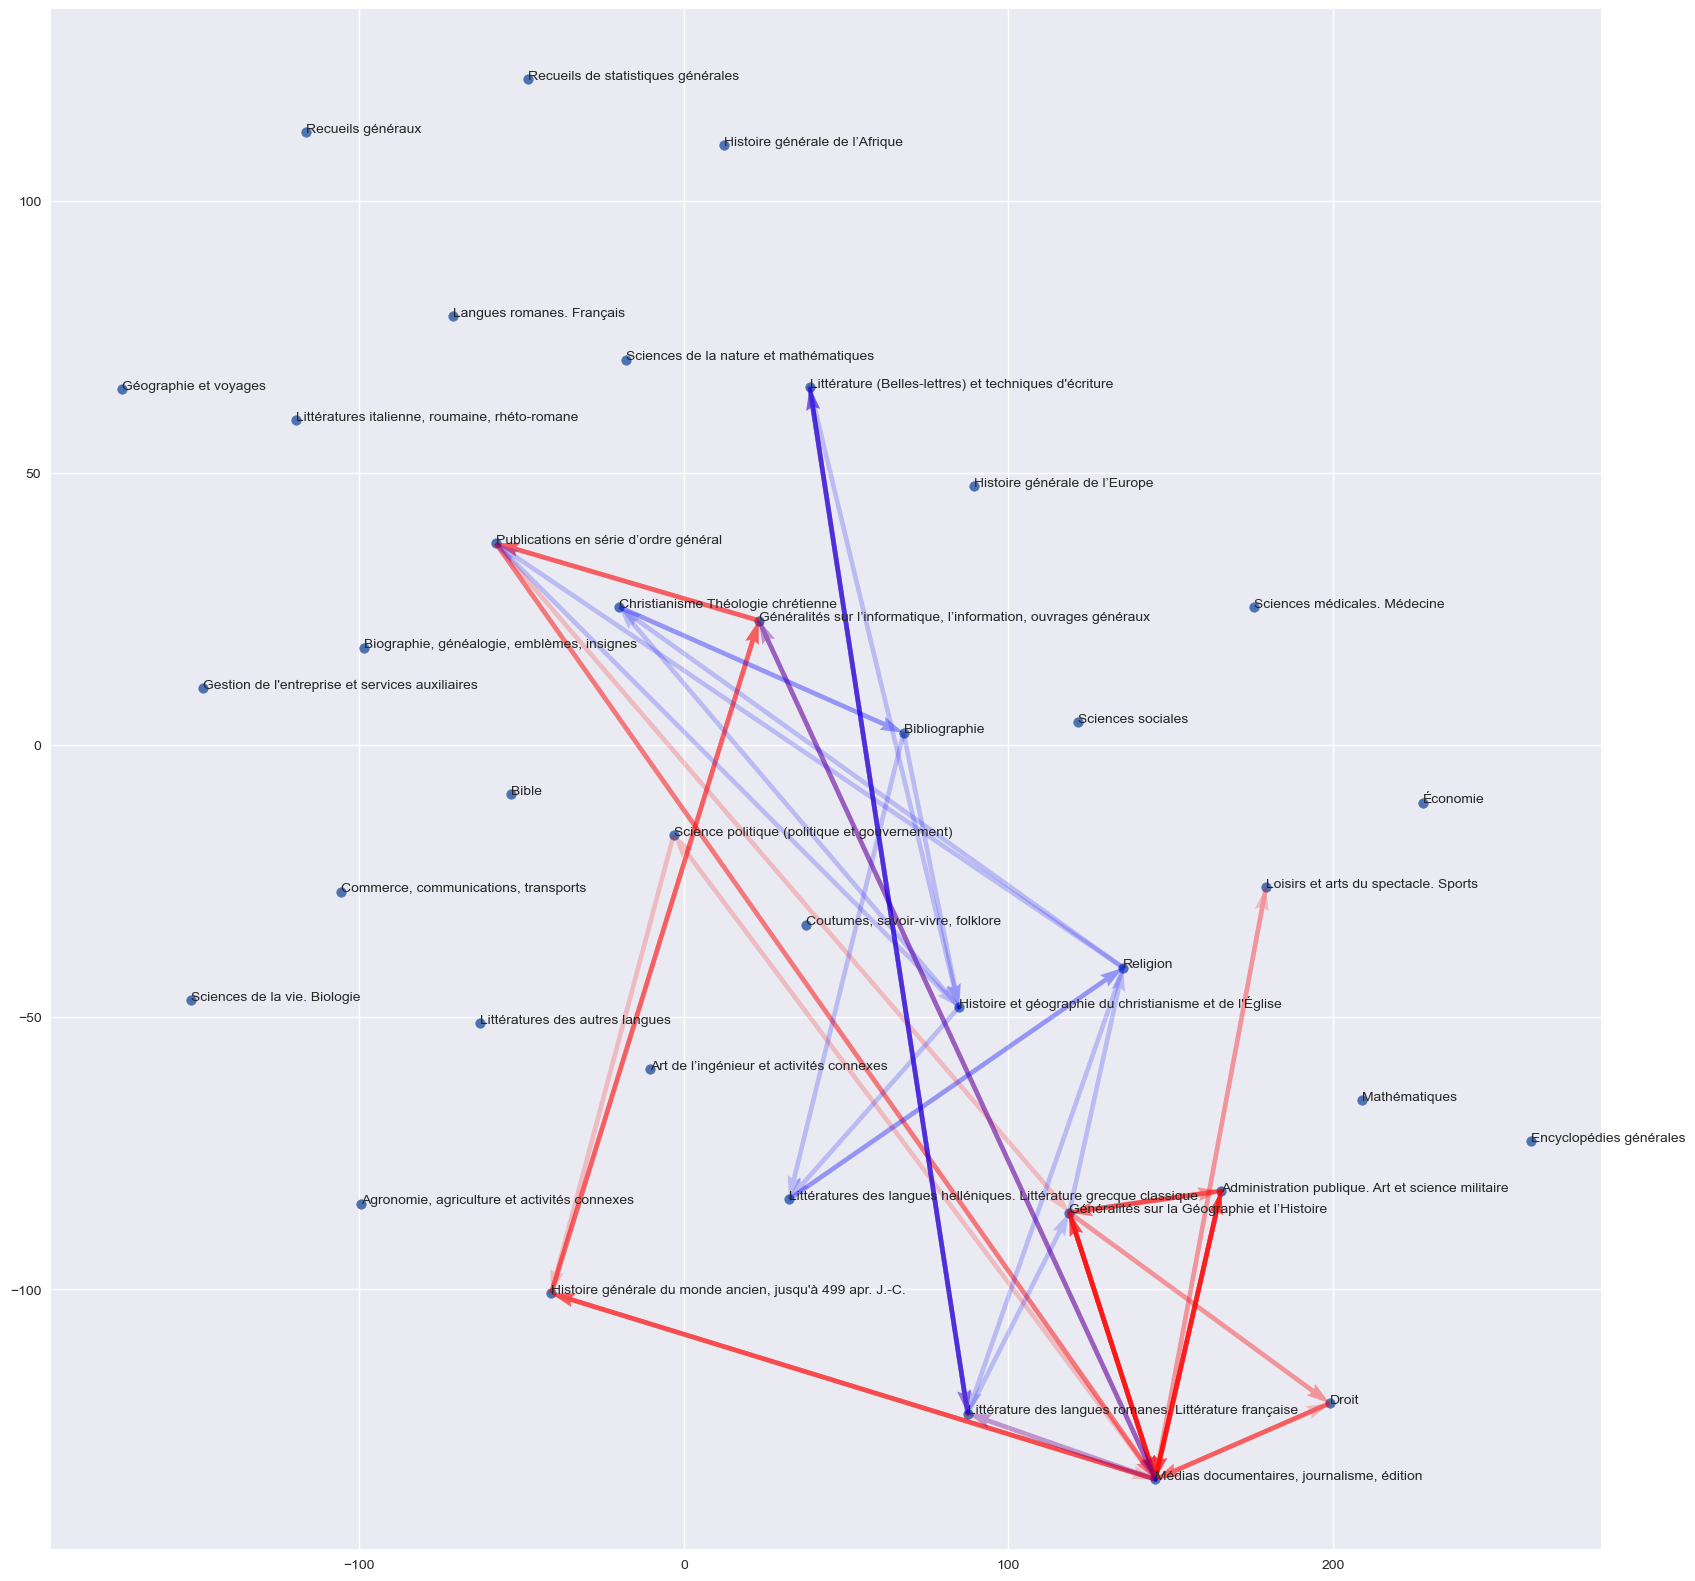

In [612]:

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
mpl.style.use('seaborn')

ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

    
# create path 1 
path_1 = list(sessions_5.iloc[10]['document_theme_path'])
path_1_vectors = []
for p in path_1:
    if p in df.index:
        path_1_vectors.append(list(df.loc[p][['x','y']]))

path_1_vectors = np.array(path_1_vectors)
    
x = path_1_vectors[:, 0]
y = path_1_vectors[:, 1]


a1 = plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,width = 0.003,color = 'red',alpha=.2 )


#create path 2 
path_2 = list(sessions_5.iloc[33]['document_theme_path'])
path_2_vectors = []
for p in path_2:
    if p in df.index:
        path_2_vectors.append(list(df.loc[p][['x','y']]))

path_2_vectors = np.array(path_2_vectors)
    
x = path_2_vectors[:, 0]
y = path_2_vectors[:, 1]


a2 = plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,width = 0.003,color = 'blue',alpha=.2 )


plt.show()

In [615]:
sessions_5.to_csv('sessions_5.csv')

TODO do this representation on all data. cluster? run everything on my laptop?

<a class="anchor" id="fourth-bullet"></a><h2><center>IV. Path representation </center></h2> 

#### 1. Example of one single path from a title/theme point of view

In [280]:
X

array([[ 2.1030593e-01, -9.6579641e-02, -1.7778802e-01, ...,
        -3.7301481e-02, -2.0687221e-01,  2.6525205e-01],
       [ 2.8611746e-01,  1.5533312e-01,  6.0935602e-02, ...,
        -3.0739304e-01,  3.6186520e-02,  4.4252855e-01],
       [ 3.6669966e-02,  3.9688777e-02,  1.1564724e-01, ...,
        -8.1074901e-02, -1.9297756e-01,  1.6656157e-01],
       ...,
       [ 2.0226172e-01,  3.0654378e-02,  4.7618899e-02, ...,
         1.0502885e-02, -3.9631528e-01,  2.0198436e-01],
       [-2.6769389e-03, -2.0928332e-03, -2.3426041e-05, ...,
         2.2033833e-03, -3.8565607e-03,  9.9877827e-04],
       [ 5.9292670e-02,  1.3727333e-02,  5.1004346e-02, ...,
        -4.8835993e-02, -1.7025247e-01,  1.3590354e-01]], dtype=float32)

In [281]:
path_1 = list(sessions_5.iloc[1]['document_theme_path'])
path_1

['Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 "Histoire générale du monde ancien, jusqu'à 499 apr. J.-C.",
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 '',
 '',
 'Généralités sur l’informatique, l’information, ouvrages généraux',
 '',
 '',
 'Généralités sur la Géographie et l’Histoire',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 'Médias documentaires, journalisme, édition',
 '

In [288]:
path_1_vectors = np.array(list(map(lambda x: list(df.loc[x][['x','y']]) ,path_1)))

In [289]:
path_1_vectors.size

88

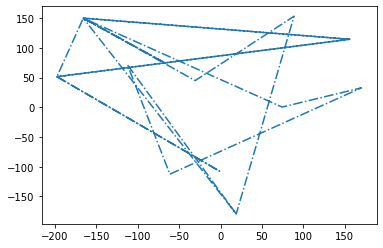

In [290]:
path_1_vectors
plt.quiver(path_1_vectors[:, 0], path_1_vectors[:, 1],scale_units='xy', angles='xy', scale=1)

In [292]:
x = path_1_vectors[:, 0]
y = path_1_vectors[:, 1]



In [286]:
path_1_vectors[0]

array([ 89.20058441, -87.20388794])

In [252]:
<a class="anchor" id="first-bullet"></a><h2><center>I. Exploring Gallica Logs</center></h2> 

SyntaxError: invalid syntax (<ipython-input-252-a9459f81c046>, line 1)